In [40]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
print(os.listdir("../input"))

!pip install -U efficientnet

['test', 'train', 'train.csv', 'sample_submission.csv']
Requirement already up-to-date: efficientnet in /opt/conda/lib/python3.6/site-packages (0.0.3)
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [41]:
base_dir = "../input/"
train_dir = os.path.join(base_dir,"train/train")
test_dir = os.path.join(base_dir, "test/test")

print("Training images : \n{}".format(os.listdir(train_dir)[:10]), end='\n\n')
print("Testing images : \n{}".format(os.listdir(test_dir)[:10]))

testing_dir = os.path.join(base_dir, "test")

Training images : 
['711c8a3efdfd2d7fa004b880970b8b6d.jpg', 'da197af684a4210c8173133a401a8b41.jpg', 'bcba2dfd2645c77e5803c7f028466abe.jpg', '1b29452f094c9e23f204b4dce356adcb.jpg', '4a627bf44c88f8bfd1f509b31fde0cc7.jpg', '15de1f86c0d0b569ce981ea9e6c82b99.jpg', 'f204268d009670aca50e65e4aed82462.jpg', 'fe329535336125c4d52b195f1a85fdd0.jpg', '33ff0f6eec09dc7fcc7622eb63413865.jpg', 'b24c1271f120ca2ab98b81fbdc602274.jpg']

Testing images : 
['6a571b6df250e9575fb82f8904c325a1.jpg', '2edb0bf826248b088d57e22799464c41.jpg', 'ea9422f63363a362ba6f482617006e76.jpg', '1021509e308bf12f71a01cac2ddca97f.jpg', '5eacbb413e5cd4e73cb7b1936758abf1.jpg', '861dccb4950b74108760daae0a1e016b.jpg', '6472fab8708bcd522836a9f1c6e9aae6.jpg', '3a77f9113b60c62b7d30c5f41828ab6b.jpg', '305d9cefe442e30abae64d84ecc8340e.jpg', '71957d3a60ca371e441fb6ff5ee6379f.jpg']


In [42]:
train_dataframe = pd.read_csv("../input/train.csv")
train_dataframe["has_cactus"] = np.where(train_dataframe["has_cactus"] == 1, "yes", "no")
print(train_dataframe.head())

                                     id has_cactus
0  0004be2cfeaba1c0361d39e2b000257b.jpg        yes
1  000c8a36845c0208e833c79c1bffedd1.jpg        yes
2  000d1e9a533f62e55c289303b072733d.jpg        yes
3  0011485b40695e9138e92d0b3fb55128.jpg        yes
4  0014d7a11e90b62848904c1418fc8cf2.jpg        yes


In [43]:
import keras
from keras.models import Sequential
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from keras import applications

from efficientnet import EfficientNetB3

In [44]:
len(train_dataframe)*0.20,len(train_dataframe)*0.80

(3500.0, 14000.0)

In [45]:
train_datagen = ImageDataGenerator(
    rescale=1/255,
    validation_split=0.10,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
shuffeled_df=train_dataframe.sample(frac=1)
train_generator = train_datagen.flow_from_dataframe(
    dataframe = shuffeled_df[:14000],
    directory = train_dir,
    x_col="id",
    y_col="has_cactus",
    target_size=(32,32),
    batch_size=250,
    shuffle=True,
    class_mode="binary"
)
valid_datagen = ImageDataGenerator(
    rescale=1/255
)
valid_generator = valid_datagen.flow_from_dataframe(
    dataframe = shuffeled_df[14000:],
    directory = train_dir,
    x_col="id",
    y_col="has_cactus",
    target_size=(32,32),
    batch_size=125,
    shuffle=True,
    class_mode="binary"
)

Found 14000 images belonging to 2 classes.
Found 3500 images belonging to 2 classes.


In [46]:
test_datagen = ImageDataGenerator(
    rescale=1/255
)

test_generator = test_datagen.flow_from_directory(
    testing_dir,
    target_size=(32,32),
    batch_size=1,
    shuffle=False,
    class_mode=None
)

Found 4000 images belonging to 1 classes.


In [47]:
pretrained_net = EfficientNetB3(
    weights='imagenet',
    input_shape=(32,32,3),
    include_top=False,
    pooling='avg'
)
model = Sequential()
model.add(pretrained_net)
model.add(Dropout(rate = 0.1))
model.add(Dense(units = 1, activation='sigmoid'))

In [48]:
model.compile(optimizer=keras.optimizers.Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [49]:
history = model.fit_generator(
    train_generator,
    epochs = 20,
    steps_per_epoch = train_generator.n//train_generator.batch_size,
    validation_data = valid_generator,
    validation_steps = valid_generator.n//valid_generator.batch_size
)

Epoch 1/20
56/56 [==============================] - 60s 1s/step - loss: 0.4619 - acc: 0.7661 - val_loss: 0.3003 - val_acc: 0.8866
Epoch 2/20
56/56 [==============================] - 17s 311ms/step - loss: 0.2141 - acc: 0.9194 - val_loss: 0.1800 - val_acc: 0.9520
Epoch 3/20
56/56 [==============================] - 19s 332ms/step - loss: 0.1399 - acc: 0.9516 - val_loss: 0.0956 - val_acc: 0.9709
Epoch 4/20
56/56 [==============================] - 19s 336ms/step - loss: 0.1046 - acc: 0.9638 - val_loss: 0.0516 - val_acc: 0.9826
Epoch 5/20
56/56 [==============================] - 19s 332ms/step - loss: 0.0785 - acc: 0.9729 - val_loss: 0.0409 - val_acc: 0.9860
Epoch 6/20
56/56 [==============================] - 19s 334ms/step - loss: 0.0700 - acc: 0.9751 - val_loss: 0.0310 - val_acc: 0.9900
Epoch 7/20
56/56 [==============================] - 19s 333ms/step - loss: 0.0557 - acc: 0.9819 - val_loss: 0.0237 - val_acc: 0.9923
Epoch 8/20
56/56 [==============================] - 19s 337ms/step - los

In [50]:
import keras.backend as K
K.set_value(model.optimizer.lr,0.00001)

In [51]:
history = model.fit_generator(
    train_generator,
    epochs = 5,
    steps_per_epoch = train_generator.n//train_generator.batch_size,
    validation_data = valid_generator,
    validation_steps = valid_generator.n//valid_generator.batch_size
)

Epoch 1/5
56/56 [==============================] - 20s 358ms/step - loss: 0.0217 - acc: 0.9918 - val_loss: 0.0095 - val_acc: 0.9957
Epoch 2/5
56/56 [==============================] - 19s 335ms/step - loss: 0.0197 - acc: 0.9925 - val_loss: 0.0095 - val_acc: 0.9954
Epoch 3/5
56/56 [==============================] - 19s 337ms/step - loss: 0.0200 - acc: 0.9934 - val_loss: 0.0114 - val_acc: 0.9949
Epoch 4/5
56/56 [==============================] - 19s 333ms/step - loss: 0.0215 - acc: 0.9915 - val_loss: 0.0116 - val_acc: 0.9951
Epoch 5/5
56/56 [==============================] - 19s 335ms/step - loss: 0.0198 - acc: 0.9933 - val_loss: 0.0114 - val_acc: 0.9954


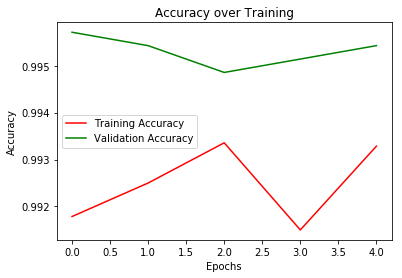

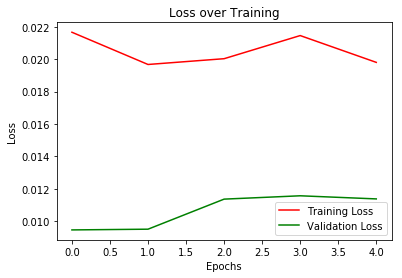

In [52]:
acc, loss = history.history['acc'], history.history['loss']
val_acc, val_loss = history.history['val_acc'], history.history['val_loss']

epochs = len(acc)

import matplotlib.pyplot as plt

plt.plot(range(epochs), acc, color='red', label='Training Accuracy')
plt.plot(range(epochs), val_acc, color='green', label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

plt.plot(range(epochs), loss, color='red', label='Training Loss')
plt.plot(range(epochs), val_loss, color='green', label='Validation Loss')
plt.legend()
plt.title('Loss over Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [53]:
preds = model.predict_generator(
    test_generator,
    steps=len(test_generator.filenames)
)

In [54]:
image_ids = [name.split('/')[-1] for name in test_generator.filenames]
predictions = preds.flatten()
data = {'id': image_ids, 'has_cactus':predictions} 
submission = pd.DataFrame(data)
print(submission.head())

                                     id    has_cactus
0  000940378805c44108d287872b2f04ce.jpg  9.992955e-01
1  0017242f54ececa4512b4d7937d1e21e.jpg  9.994610e-01
2  001ee6d8564003107853118ab87df407.jpg  9.892381e-05
3  002e175c3c1e060769475f52182583d0.jpg  7.489590e-07
4  0036e44a7e8f7218e9bc7bf8137e4943.jpg  9.995395e-01


In [55]:
submission.to_csv("submission.csv", index=False)

In [57]:
def clip(x):
    if x>=0.5:
        return 0.999999
    else:
        return 0
submission.has_cactus=submission.has_cactus.apply(clip)
submission.to_csv("./submission_clipped.csv",index=False)